In [2]:
library(readr)
library(lubridate)
library(chron)
library(dplyr)
library(stringr)
library(ggplot2)

In [3]:
uber <- read_csv('Uber Request Data.csv')
head(uber)

Parsed with column specification:
cols(
  `Request id` = col_integer(),
  `Pickup point` = col_character(),
  `Driver id` = col_integer(),
  Status = col_character(),
  `Request timestamp` = col_character(),
  `Drop timestamp` = col_character()
)


Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
619,Airport,1,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
867,Airport,1,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
1807,City,1,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
2532,Airport,1,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
3112,City,1,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
3879,Airport,1,Trip Completed,13-07-2016 21:57:28,13-07-2016 22:28:59


In [4]:
# converting date from character to dttm format
uber$`Request timestamp` <- parse_date_time(uber$`Request timestamp`, orders = c('dmy HM', 'dmy HMS'))
uber$`Drop timestamp` <- parse_date_time(uber$`Drop timestamp`, orders = c('dmy HM', 'dmy HMS'))

In [5]:
# checking for missing values
colSums(sapply(uber, FUN = function(c) is.na(c)))

Request id      Pickup point         Driver id            Status 
                0                 0              2650                 0 
Request timestamp    Drop timestamp 
                0              3914

Here NAs are not missing at random. The NAs in driver id field indicate cabs are unavailable  
and those in Drop timestamp indicate the cabs unavailable + request cab drivers cancelled

In [6]:
#change column names
colnames(uber) <- str_replace_all(colnames(uber), ' ', '_')

In [7]:
# number of weekends is 0 means that we have weekdays only data
sum(is.weekend(uber$Request_timestamp))

[1] 0

In [8]:
# cab request status
uber %>% group_by(Status) %>% count()

Status,n
Cancelled,1264
No Cars Available,2650
Trip Completed,2831


In [9]:
# creating time_slots 
time_slots <- function(d){
  temp <- hour(d)
  if(temp >= 0 & temp <= 4){
    c('early_morning')
  }else if(temp > 4 & temp < 12){
    c('morning')
  }else if(temp >= 12 & temp < 16){
    c('afternoon')
  }else if(temp >= 16 & temp <= 20){
    c('evening')
  }else if(temp > 20 ){
    c('late_evening')
  }
}

uber$time_slot <- sapply(uber$Request_timestamp, FUN = time_slots) %>% as.character

In [10]:
# creating factor variable
uber$Pickup_point <- factor(uber$Pickup_point)
uber$Status <- factor(uber$Status)
uber$time_slot <- factor(uber$time_slot)

In [21]:
# resizing fig size
options(repr.plot.width=10, repr.plot.height=5)

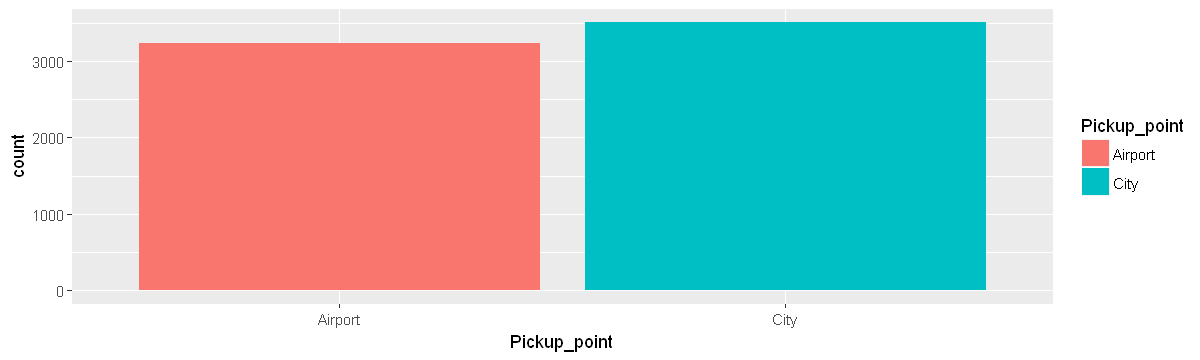

In [17]:
# city to airport trips are slightly higher than aiport to city
uber %>% ggplot(aes(x = Pickup_point, fill = Pickup_point)) + geom_bar()

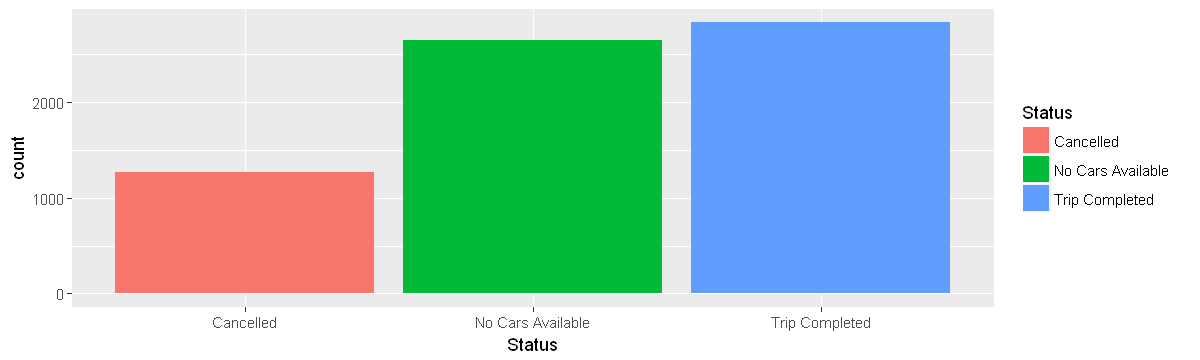

In [18]:
# significant amount of cabs are not available. Also considerable amoutn of cabs are cancelled
uber %>% ggplot(aes(x = Status, fill = Status)) + geom_bar()

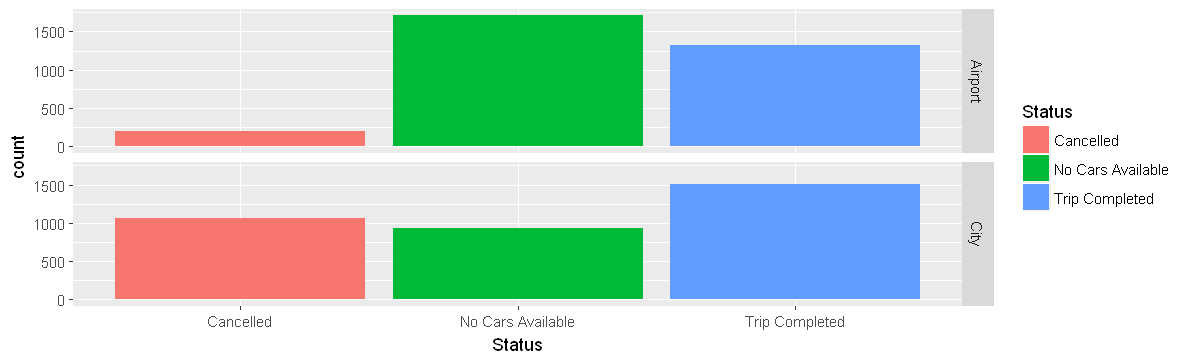

In [19]:
# more cabs are not available at the airport
# this might be because less number of cabs are entering the airport due to cancellations in the city
# more drivers are not willing to travel to the airport
uber %>% ggplot(aes(x = Status, fill = Status)) + geom_bar() + facet_grid(Pickup_point~.)

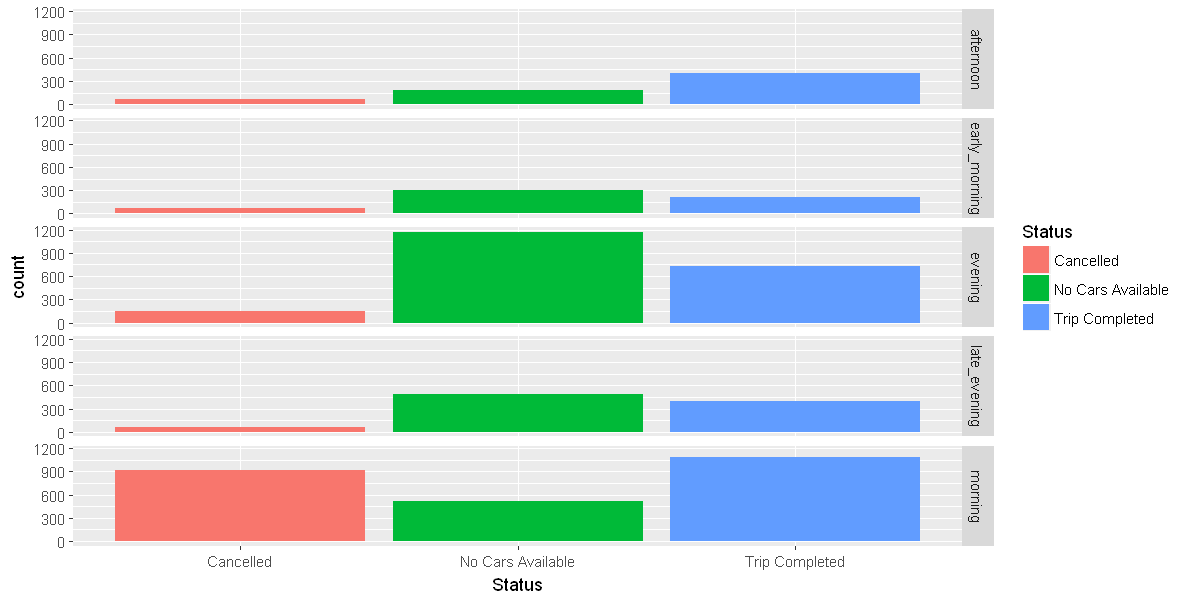

In [22]:
# cabs are getting cancellied in the morining
# also more cabs are not available in the evening
uber %>% ggplot(aes(x = Status, fill = Status)) + geom_bar() + facet_grid(time_slot~.)


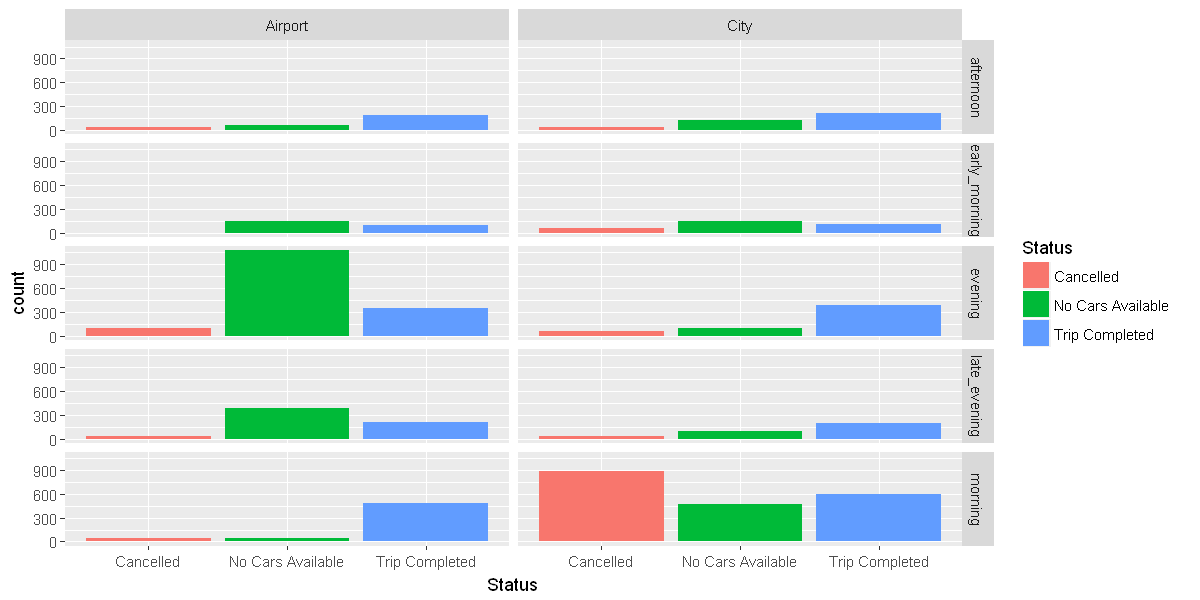

In [23]:
# as expected drivers dont want airport trips in the morning
# since less cabs travel to airport in the morning, more cabs are unavailble in the evening at airport
uber %>% ggplot(aes(x = Status, fill = Status)) + geom_bar() + facet_grid(time_slot~Pickup_point)

In [24]:
# drives with more number of cancelled airport trips
uber %>% filter(Status == 'Cancelled', Pickup_point == 'City') %>% 
  group_by(Driver_id) %>% count() %>% arrange(desc(n)) %>% head(n = 10)

Driver_id,n
84,11
54,10
142,10
27,8
131,8
177,8
206,8
44,7
70,7
114,7


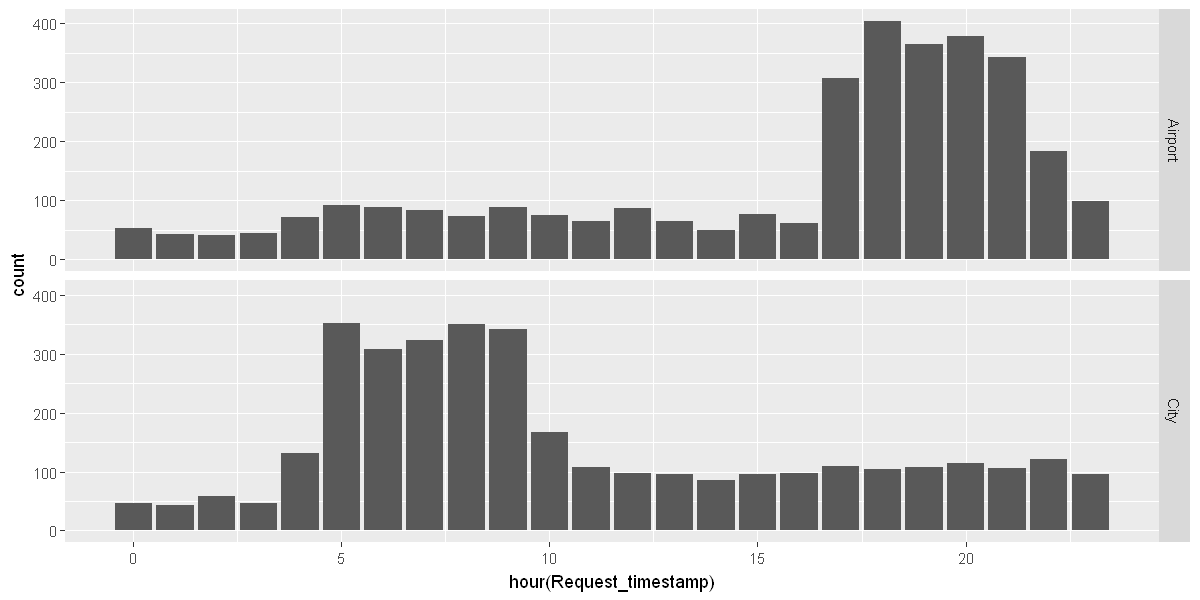

In [25]:
# in the morning more people travel to airport and in the evening more ppl travel to city
uber %>% ggplot(aes(x = hour(Request_timestamp))) + geom_bar() + facet_grid(Pickup_point~.)

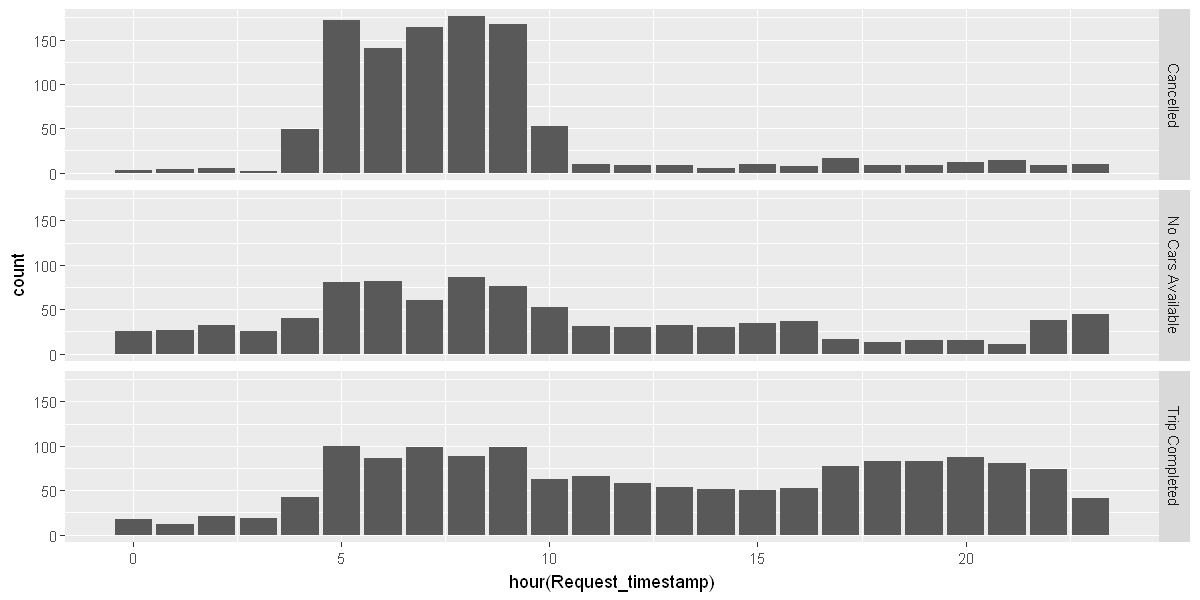

In [26]:
# though in the morining more people are willing to travel to airport
# most of those requests are cancelled by the cab drivers
uber %>% filter(Pickup_point == 'City') %>% ggplot(aes(x = hour(Request_timestamp))) + geom_bar() +
  facet_grid(Status~.)

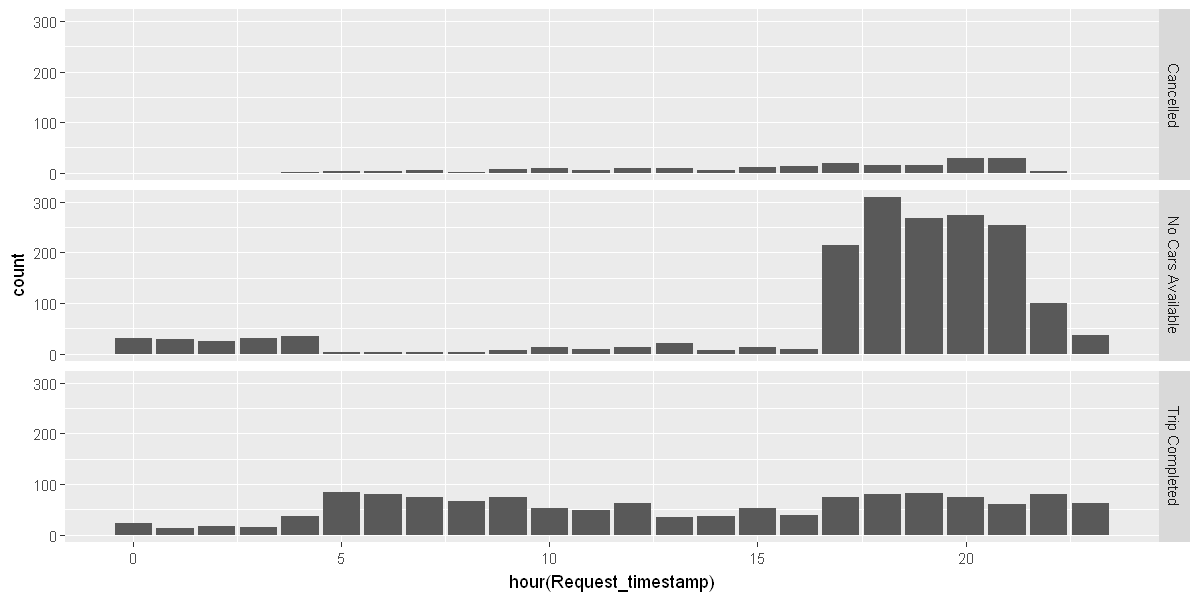

In [27]:
# as expected very few drivers reject the City trips. Also due to heavy footfall at the airport
# in the evenings more cabs are not available
uber %>% filter(Pickup_point == 'Airport') %>% ggplot(aes(x = hour(Request_timestamp))) + geom_bar() +
  facet_grid(Status~.)

In [28]:
# amount of time taken by cab rides
uber$ride_time <- uber$Drop_timestamp - uber$Request_timestamp
uber$ride_time <- round(uber$ride_time)

Warning message:
"Removed 3914 rows containing non-finite values (stat_boxplot)."

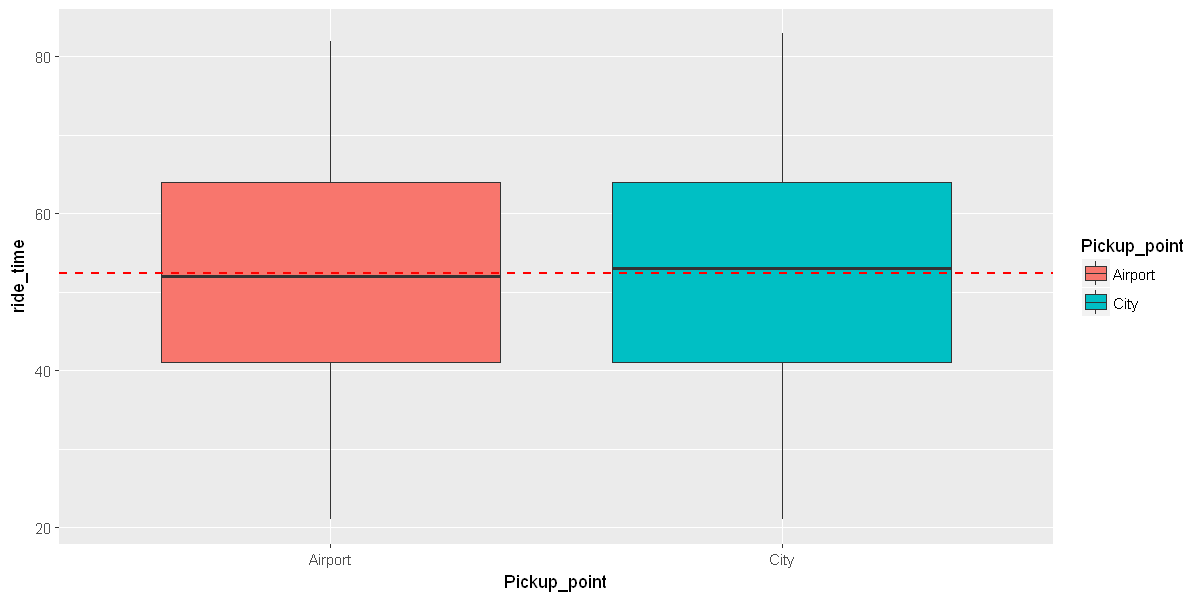

In [33]:
# mean ride time from city to airport is slightly higher
uber %>% ggplot(aes(x = Pickup_point, y = ride_time, fill = Pickup_point)) + geom_boxplot() +
  scale_y_continuous() +  geom_hline(yintercept = mean(uber$ride_time, na.rm = T), col = 'red', lwd = 0.75, linetype = 'dashed')